In [43]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

In [2]:
df = pd.read_csv("data/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Preprocessing

#### Fill missing values and convert to numerical (where possible)

In [3]:
sexes = sorted(df['Sex'].unique())
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
df['Sex_Val'] = df['Sex'].map(genders_mapping).astype(int)

In [4]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
embarked_locs = sorted(df['Embarked'].unique())
embarked_locs_mapping = dict(zip(embarked_locs, range(0, len(embarked_locs) + 1)))
df['Embarked_Val'] = df['Embarked'].map(embarked_locs_mapping).astype(int)

In [5]:
df['AgeFill'] = df['Age']
df['AgeFill'] = df['AgeFill'].groupby([df['Sex_Val'], df['Pclass']]).apply(lambda x: x.fillna(x.median()))

In [6]:
df['FamilySize'] = df['SibSp'] + df['Parch']

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Val,Embarked_Val,AgeFill,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,2,22.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,38.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,2,26.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,2,35.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,2,35.0,0


#### Check categorical variables

In [8]:
df.dtypes[df.dtypes.map(lambda x: x == 'object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [9]:
df_train = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_train = df_train.drop(['Survived', 'Age', 'SibSp', 'Parch', 'PassengerId', 'Embarked_Val', 'Sex_Val'], axis=1)
df_train.dtypes

Pclass          int64
Fare          float64
AgeFill       float64
FamilySize      int64
dtype: object

In [11]:
df_train.head()

,Pclass,Fare,AgeFill,FamilySize
0,3,7.2500,22.0,1
1,1,71.2833,38.0,1
2,3,7.9250,26.0,0
3,1,53.1000,35.0,1
4,3,8.0500,35.0,0


In [12]:
df_train.columns

Index(['Pclass', 'Fare', 'AgeFill', 'FamilySize'], dtype='object')

In [13]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_train)

### Clustering

In [15]:
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [16]:
%%time
sse_list = []
for k in range(2, 51):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)

CPU times: user 9.15 s, sys: 2.86 s, total: 12 s
Wall time: 3.81 s


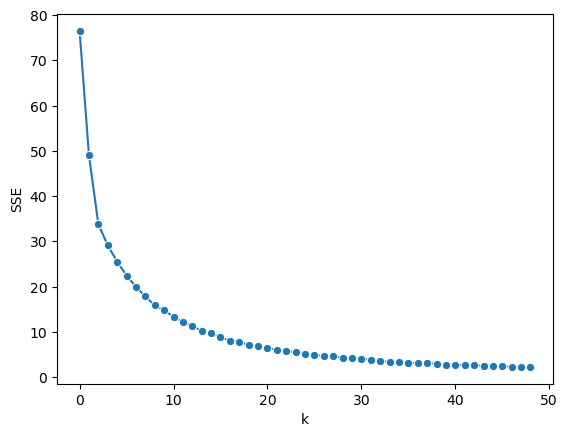

In [17]:
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [18]:
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, max_iter=100)
kmeans.fit(train_data)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(train_data, kmeans.labels_))

labels {0: 76, 1: 100, 2: 111, 3: 63, 4: 96, 5: 53, 6: 36, 7: 37, 8: 20, 9: 299}
sse 16.01019548068522
silhouette 0.45530170730447217


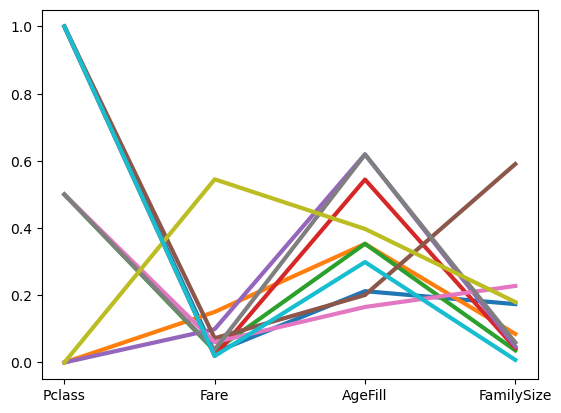

In [33]:
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 4), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(0, 4), list(df_train.columns))
plt.show()

In [34]:
df_clusters = df_train.copy()
df_clusters['Labels'] = kmeans.labels_

In [35]:
df_clusters.head()

,Pclass,Fare,AgeFill,FamilySize,Labels
0,3,7.2500,22.0,1,0
1,1,71.2833,38.0,1,1
2,3,7.9250,26.0,0,9
3,1,53.1000,35.0,1,1
4,3,8.0500,35.0,0,3


In [22]:
pclass_xt = pd.crosstab(df_clusters['Pclass'], df_clusters['Labels'])
pclass_xt

Labels,0,1,2,3,4,5,6,7,8,9
Pclass,,,,,,,,,,
1,0,100,0,0,96,0,0,0,20,0
2,0,0,111,0,0,0,36,37,0,0
3,76,0,0,63,0,53,0,0,0,299


In [23]:
psurv_xt = pd.crosstab(df['Survived'], df_clusters['Labels'])
psurv_xt = pd.crosstab(df_clusters['Labels'], df['Survived'])

psurv_xt

Survived,0,1
Labels,,
0,34,42
1,20,80
2,70,41
3,57,6
4,54,42
5,49,4
6,6,30
7,21,16
8,6,14


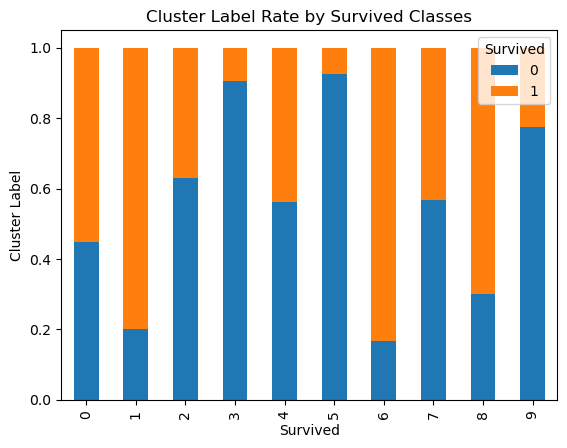

In [24]:
psurv_xt_pct = psurv_xt.div(psurv_xt.sum(1).astype(float), axis=0)
psurv_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Survived Classes')
plt.xlabel('Survived')
plt.ylabel('Cluster Label')
plt.show()

In [36]:
df_clusters[df_clusters['Labels']==3].describe()

,Pclass,Fare,AgeFill,FamilySize,Labels
count,63.0,63.000000,63.000000,63.000000,63.0
mean,3.0,9.941137,43.746032,0.428571,3.0
std,0.0,5.542543,8.793726,0.836935,0.0
min,3.0,0.000000,34.000000,0.000000,3.0
25%,3.0,7.522900,37.500000,0.000000,3.0
50%,3.0,7.925000,42.000000,0.000000,3.0
75%,3.0,9.531250,47.000000,0.500000,3.0
max,3.0,34.375000,74.000000,4.000000,3.0


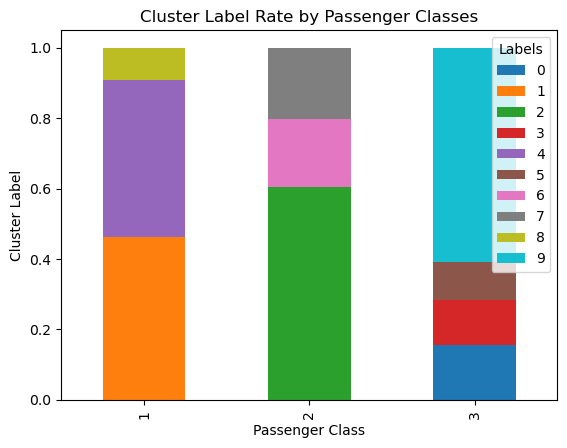

In [37]:
pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)
pclass_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Passenger Classes')
plt.xlabel('Passenger Class')
plt.ylabel('Cluster Label')
plt.show()

### Hierarchical

In [41]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [39]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(train_data)

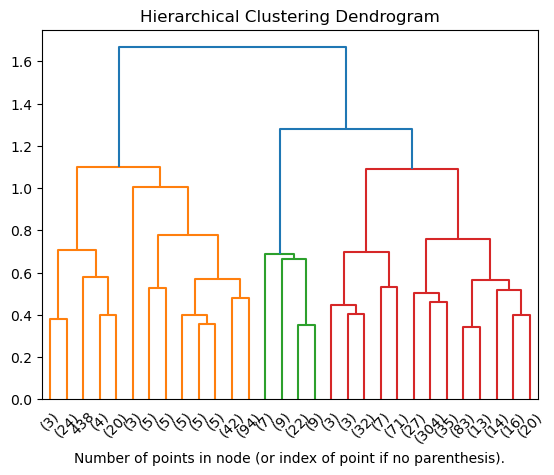

In [44]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [45]:
hier = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
hier.fit(train_data)

AgglomerativeClustering(linkage='complete', n_clusters=3)

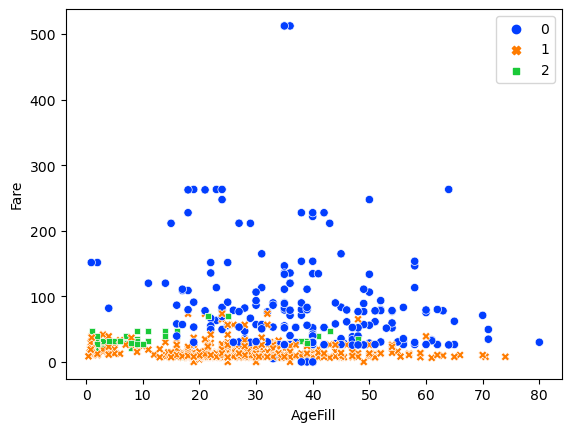

In [46]:
sns.scatterplot(data=df_clusters, x="AgeFill", y="Fare", hue=hier.labels_, 
                style=hier.labels_, palette="bright")
plt.show()

#### connectivity constraint

In [50]:
# hierarchical clustering
connectivity = kneighbors_graph(train_data, n_neighbors=100, include_self=False)

In [51]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                linkage='ward', connectivity=connectivity)
model = model.fit(train_data)

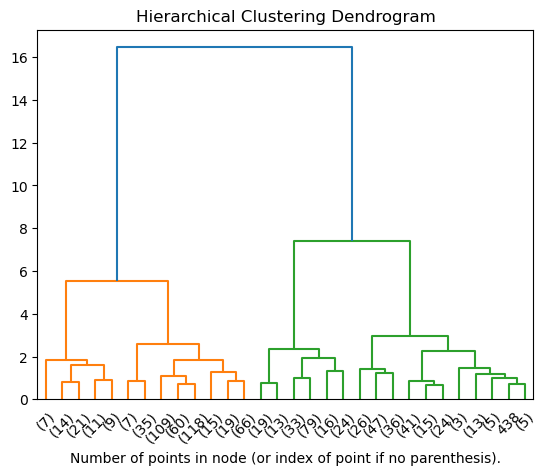

In [52]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [53]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean',
                                   connectivity=connectivity)
ward.fit(train_data)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, ward.labels_))

labels {0: 491, 1: 216, 2: 184}
silhouette 0.5676262875725462


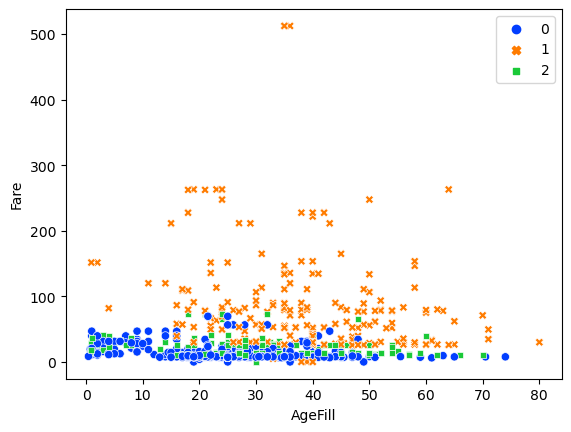

In [54]:
sns.scatterplot(data=df_clusters, x="AgeFill", y="Fare", hue=ward.labels_, 
                style=ward.labels_, palette="bright")
plt.show()

In [55]:
print('average linkage')
average_linkage = AgglomerativeClustering(n_clusters=3, linkage='average', affinity='manhattan',
                                              connectivity=connectivity)
average_linkage.fit(train_data)

hist, bins = np.histogram(average_linkage.labels_, 
                          bins=range(0, len(set(average_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, average_linkage.labels_))

average linkage
labels {0: 881, 1: 7, 2: 3}
silhouette 0.37132365914471405


In [56]:
print('complete linkage')
complete_linkage = AgglomerativeClustering(n_clusters=3, linkage='complete', affinity='l1',
                                              connectivity=connectivity)
complete_linkage.fit(train_data)
hist, bins = np.histogram(complete_linkage.labels_, 
                          bins=range(0, len(set(complete_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, complete_linkage.labels_))

complete linkage
labels {0: 882, 1: 3, 2: 6}
silhouette 0.35741232675404144


### DBScan

In [69]:
# density based clustering
print('dbscan')

dbscan = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
dbscan.fit(train_data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, dbscan.labels_))

dbscan
labels {-1: 5, 0: 484, 1: 207, 2: 183, 3: 5, 4: 7, 5: 0}
silhouette 0.5638471729231701


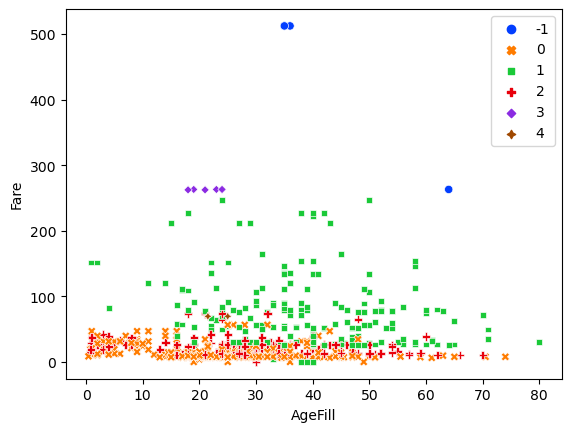

In [70]:
sns.scatterplot(data=df_clusters, x="AgeFill", y="Fare", hue=dbscan.labels_, 
                style=dbscan.labels_, palette="bright")
plt.show()